In [1]:
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt 


In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
train_data = datasets.MNIST(root="../data", train=True, 
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(root="../data", train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [3]:
class CVAE(nn.Module):
    def __init__(self, dim_x, dim_y):

        super().__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=dim_x**2, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=dim_y),
            nn.Softmax()
        )

    def forward(self, x):
        c_out = self.classifier(x)
        return c_out # ,enc_cond_out

model = CVAE(28, 10).to(device)

In [4]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

In [5]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [6]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 10

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model.train() 
        # 1. Forward pass
        X = X.to(device)
        y = y.to(device)
        y = torch.nn.functional.one_hot(y, 10).to(torch.float32)
        y_pred = model(X)
        
        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device)
            y = y.to(device)    
            y = torch.nn.functional.one_hot(y, 10).to(torch.float32)
            # 1. Forward pass
            test_pred = model(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y.argmax(dim=1), y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.32259 | Test loss: 0.32020, Test acc: 21.33%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.31774 | Test loss: 0.31513, Test acc: 43.06%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.31260 | Test loss: 0.30966, Test acc: 54.02%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.30703 | Test loss: 0.30371, Test acc: 60.14%

Epoch: 4
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60

tensor([4], device='cuda:0')


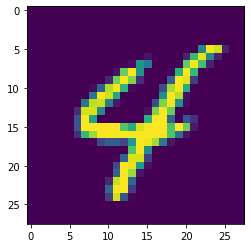

In [9]:
inp = train_data[541][0]
plt.imshow(inp.squeeze())
out=torch.argmax(model(inp.to(device)), axis=1)
print(out)